In [0]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:

# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

import os
os.environ['KAGGLE_USERNAME'] = "montysteele" # username from the json file
os.environ['KAGGLE_KEY'] = "a3b1a776c48c701e0adcfc08a8d23c22" # key from the json file
!kaggle datasets download -d rhammell/ships-in-satellite-imagery # api copied from kaggle

 98% 181M/185M [00:04<00:00, 39.3MB/s]
100% 185M/185M [00:04<00:00, 46.0MB/s]


In [0]:
from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('ships-in-satellite-imagery.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [0]:
!mkdir ship
!mkdir noship

! cp shipsnet/shipsnet/0* noship
! cp shipsnet/shipsnet/1* ship

!mkdir data
!mv  ship data
!mv  noship data

In [0]:
#!ls shipsnet/shipsnet #&& ls -1 | wc -l # 4000 files as expected
!ls data

noship	ship


In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 160
IMG_WIDTH = 160

split_size = 0.2

train_data_dir = '/content/data'

total_images = 4000
total_train = total_images*split_size
total_val = total_images*(1 - split_size)

print(total_train)
print(total_val)

800.0
3200.0


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=45,
    horizontal_flip=True,
    validation_split=split_size) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation') # set as validation data


Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

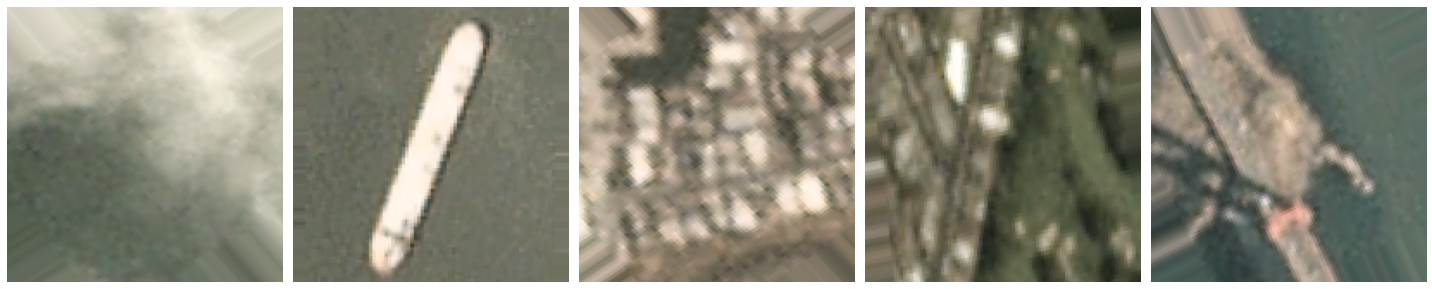

In [0]:
sample_training_images, _ = next(train_generator)

plotImages(sample_training_images[:5])

In [0]:
'''
base_model = tf.keras.applications.vgg19.VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), 
                                               include_top=False, weights='imagenet')
# ~85% after 15 epochs

'''

'''
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, 
                                                         weights='imagenet', input_shape=None)
# ~96% after 15 epochs  

'''


base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')

# ~98.6% after 15 epochs
# ~99% after 50 epochs


'''
base_model = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_tensor=None, 
                                                     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# ~96.9%
'''

"\nbase_model = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_tensor=None, \n                                                     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))\n\n# ~96.9%\n"

In [0]:
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
mid_layer = tf.keras.layers.Dense(4096)
prediction_layer = tf.keras.layers.Dense(1)

In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  mid_layer,
  prediction_layer
])

base_learning_rate = 5e-6
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              5246976   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4097      
Total params: 7,509,057
Trainable params: 5,251,073
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/15
6/6 [==============================] - 21s 3s/step - loss: 0.6742 - accuracy: 0.6758 - val_loss: 0.5134 - val_accuracy: 0.8005
Epoch 2/15
6/6 [==============================] - 20s 3s/step - loss: 0.4995 - accuracy: 0.7435 - val_loss: 0.4683 - val_accuracy: 0.7447
Epoch 3/15
6/6 [==============================] - 20s 3s/step - loss: 0.4044 - accuracy: 0.7812 - val_loss: 0.4170 - val_accuracy: 0.7397
Epoch 4/15
6/6 [==============================] - 20s 3s/step - loss: 0.3579 - accuracy: 0.7747 - val_loss: 0.3177 - val_accuracy: 0.8118
Epoch 5/15
6/6 [==============================] - 20s 3s/step - loss: 0.3023 - accuracy: 0.8177 - val_loss: 0.3019 - val_accuracy: 0.8374
Epoch 6/15
6/6 [==============================] - 20s 3s/step - loss: 0.2787 - accuracy: 0.8372 - val_loss: 0.2886 - val_accuracy: 0.8331
Epoch 7/15
6/6 [==============================] - 20s 3s/step - loss: 0.2690 - accuracy: 0.8607 - val_loss: 0.2536 - val_accuracy: 0.8623
Epoch 8/15
6/6 [==================

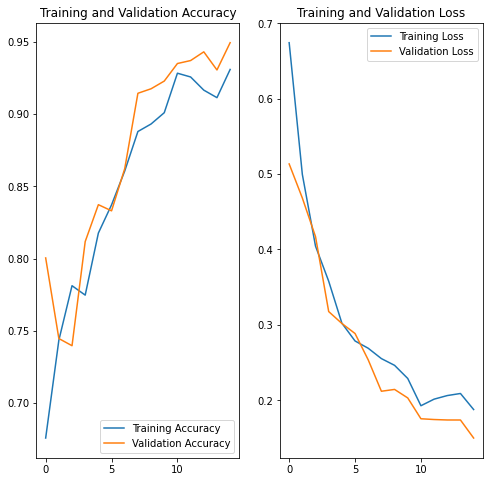

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)
#epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()